# Scanpy: Annotation Final

Final version of annotation.

### Setup and Load Data

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import scipy.sparse
import cmasher as cmr
from natsort import natsorted
import sys 
import os
import gc
sys.path.append(os.path.abspath("D:\jupyter_3_10\jl_modules"))
import sc_module as sm

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80)

# *** Input File ***  h5 file  
sample_name = r'sc92'
h5_file_path = r'results/'
clustered_file = h5_file_path + sample_name + '_clustered.h5ad'

# filtered data to be updated with cluster information
filtered_file = h5_file_path + sample_name + '_filt.h5ad'

# *** Output File ***  h5 file  
final_file = h5_file_path + sample_name + r'_final.h5ad'
final_filtered_file = h5_file_path + sample_name + r'_final_raw.h5ad'  # the file that will store the raw counts after removal of cells

scanpy==1.10.1 anndata==0.8.0 umap==0.5.3 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.1.1 statsmodels==0.14.2 igraph==0.10.8 louvain==0.8.2 pynndescent==0.5.7


### Read data

In [2]:
# clustered data
adata = sc.read_h5ad(clustered_file)
adata.uns['log1p']["base"] = None    # bug fix

print(adata.obs['sample'].value_counts())
print()
print('X matrix is sparse:', scipy.sparse.issparse(adata.X))
print('X size =', adata.X.shape)

sample
60day3    12058
60day1    10254
60day2     9609
Name: count, dtype: int64

X matrix is sparse: False
X size = (31921, 24178)


### Subset clusters

In [8]:
i=0
new_col = []
for item in adata.obs['leiden_1.4']:
    if item == '2' and adata.obs['kmeans'].iloc[i] == '56': 
        pass
#         new_col.append('2b')  
#     elif item == '19' and adata.obs['leiden_2.0'].iloc[i] == '36':   
#         new_col.append('19b')
#     elif item == '21' and adata.obs['leiden_1.7'].iloc[i] == '24': 
#         new_col.append('21b')
#     elif item == '15' and adata.obs['leiden_1.7'].iloc[i] == '25': 
#         new_col.append('15b')
#     elif item == '8' and adata.obs['hclust'].iloc[i] == '79': 
#         new_col.append('8c')
#     elif item == '8' and adata.obs['hclust'].iloc[i] == '97': 
#         new_col.append('8d')
#     elif item in ['5','9'] and adata.obs['hclust'].iloc[i] in ['102','8','90']:
#         new_col.append('Th1')
#     elif item in ['5','9'] and adata.obs['hclust'].iloc[i] == '2':
#         new_col.append('Tex')
#     elif item in ['5','9'] and adata.obs['hclust'].iloc[i] == '83':
#         new_col.append('Treg')
#     elif item in ['5','9'] and adata.obs['hclust'].iloc[i] in ['92','113','48']:
#         new_col.append('Tnaive')
#     elif item in ['5','9'] and adata.obs['hclust'].iloc[i] in ['41','73','29','56']:
#         new_col.append('T')
    else:
        new_col.append(item)
    i = i+1
adata.obs['my_clust_1'] = new_col
adata.obs['my_clust_1'] = adata.obs['my_clust_1'].astype('category')
cluster_type = "my_clust_1"

### Merge Clusters
Merge clusters 1 and 2,
14 and 14b

In [9]:
# i=0
# new_col = []
# for item in adata.obs['my_clust_1']:
#     if item == '14b':
#         new_col.append('14')
#     else:
#         new_col.append(item)
#     i = i+1   
    
# adata.obs['my_clust_1'] = new_col
# adata.obs['my_clust_1'] = adata.obs['my_clust_1'].astype('category')

### Top Level Annotation Dictionary
Look at broad markers.

In [10]:
broad_marker_genes = dict()
broad_marker_genes['immune'] = ['Ptprc','Dock2']
broad_marker_genes['mesothelial'] = ['Upk3b',  'Wt1', 'Msln', 'Wt1os']
broad_marker_genes['stromal'] = ['Ism1', 'Adcy2'] # 'Col1a1'
broad_marker_genes['endothelial'] = ['Pecam1','Adgrl4', 'Calcrl', 'Cyyr1', 'Ldb2','Shank3','Egfl7']
broad_marker_genes['epithelial'] = ['Prdm16', 'Nkx2-1', 'Sfta3-ps', 'Eya2',  'Chka', 'Pip5k1b'] # 'Epcam'
broad_marker_genes['muscle'] = ['Trpc6', 'Notch3'] # 'Myh11'

broad_marker_genes, msg = sm.validate_dict(broad_marker_genes, adata.var_names)
print(msg)
top_level_cell_types = list(broad_marker_genes.keys())


gene_dict = broad_marker_genes
# add cell type scores to .obs
for key in gene_dict:
    genes = gene_dict[key]
    markers_df = adata[:,genes].to_df()
    for column in markers_df.columns:
        n = 2 # min max normalization, use average of n values to calculate min max
        markers_df[column] = (markers_df[column] - markers_df[column].nsmallest(n).mean()) 
        markers_df[column] = markers_df[column] / markers_df[column].nlargest(n).mean()
    markers_df[key] = markers_df.mean(axis=1)
    adata.obs[key] = markers_df[key]

In [11]:
for key in gene_dict:
    genes = gene_dict[key]
#     print(key, genes)
    print (key, '\t','%s' % ', '.join(map(str, gene_dict[key])))

immune 	 Ptprc, Dock2
mesothelial 	 Upk3b, Wt1, Msln, Wt1os
stromal 	 Ism1, Adcy2
endothelial 	 Pecam1, Adgrl4, Calcrl, Cyyr1, Ldb2, Shank3, Egfl7
epithelial 	 Prdm16, Nkx2-1, Sfta3-ps, Eya2, Chka, Pip5k1b
muscle 	 Trpc6, Notch3


### Initial data plots

<Axes: title={'center': 'stromal'}, xlabel='UMAP1', ylabel='UMAP2'>

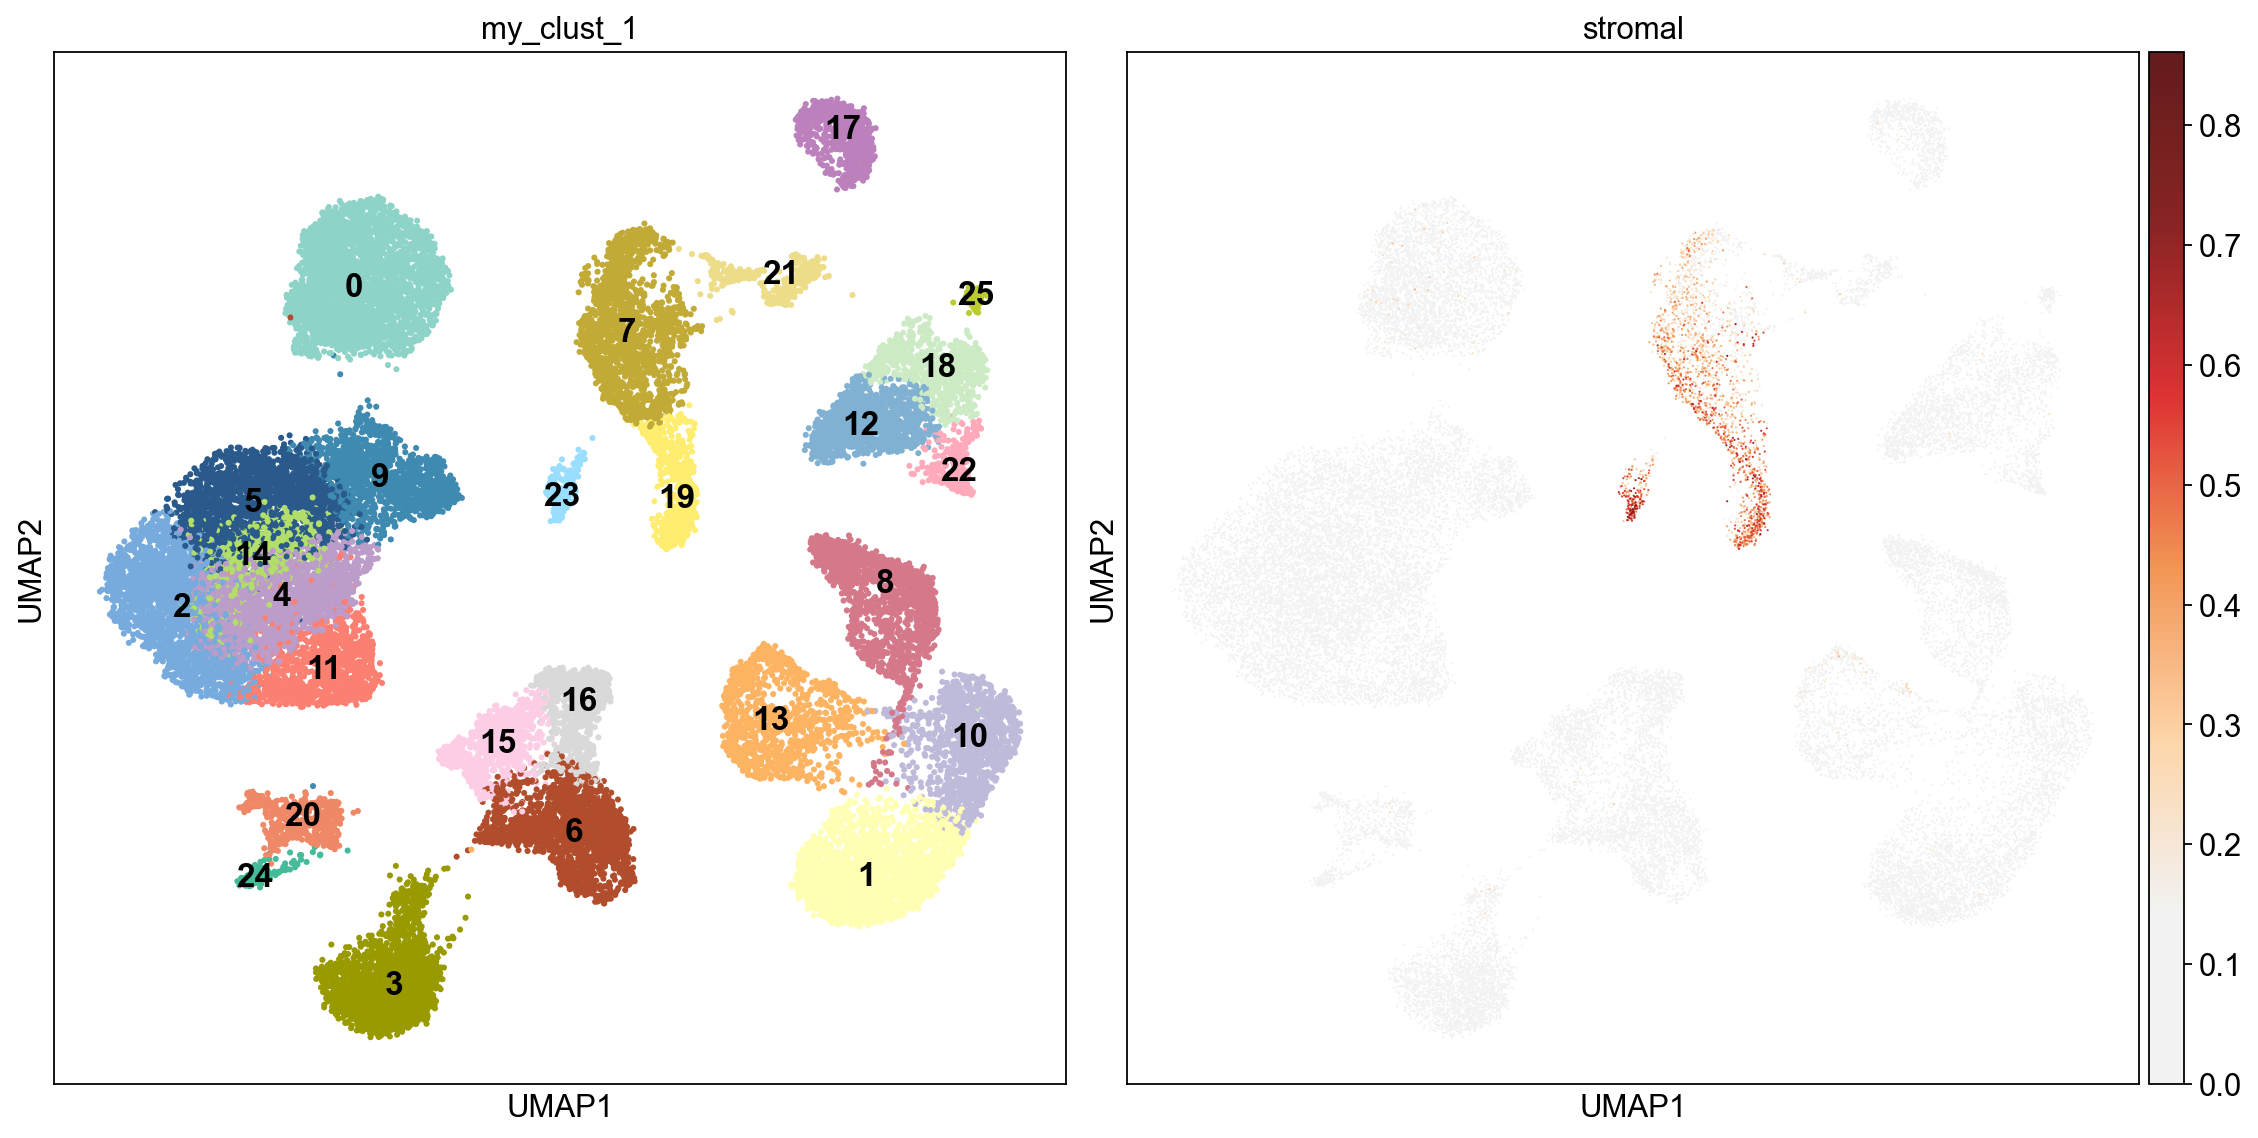

In [16]:
test_gene = 'stromal' # ''Arhgef37', 'Plac8', 'Adgre4'
plt.rcParams.update({'font.size': 15})   # cluster labels
fig, axs = plt.subplots(1, 2, figsize=(14,7),constrained_layout=True)
sc.pl.umap(adata, color=cluster_type, size=30, ax=axs[0], show=False, legend_loc='on data', palette=sm.wes)
sc.pl.umap(adata, color_map=sm.fire, color=test_gene, ax=axs[1], show=False)

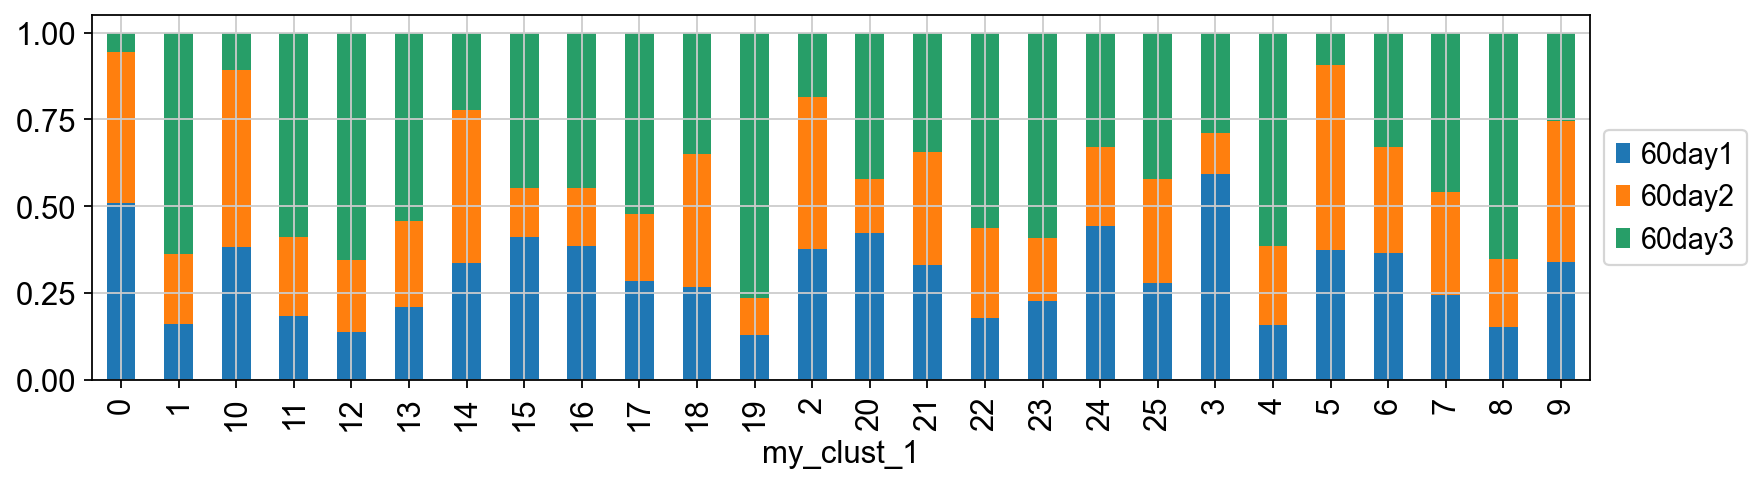

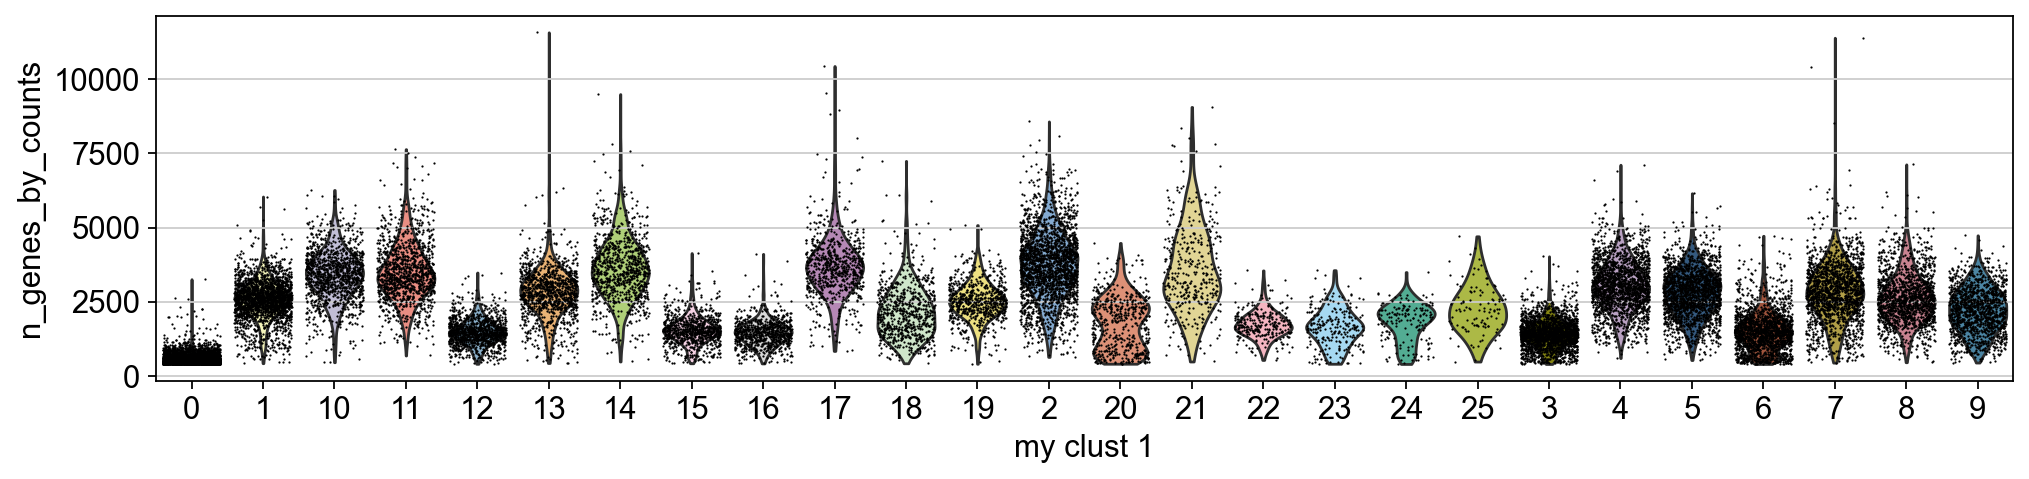

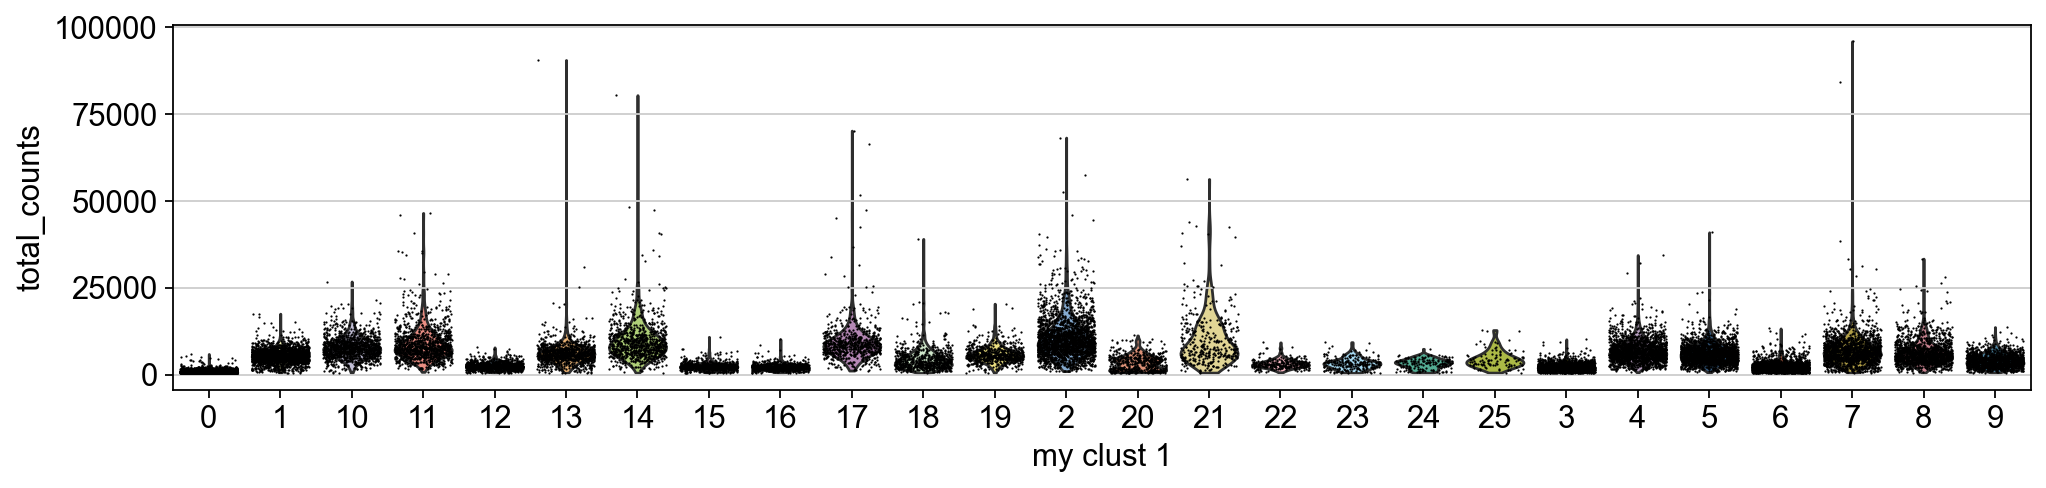

In [13]:
rcParams['figure.figsize'] = 12, 3
tmp = pd.crosstab(adata.obs[cluster_type],adata.obs['sample'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax = sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, groupby=cluster_type, show=False)
ax = sc.pl.violin(adata, ['total_counts'], jitter=0.4, groupby=cluster_type, show=False)

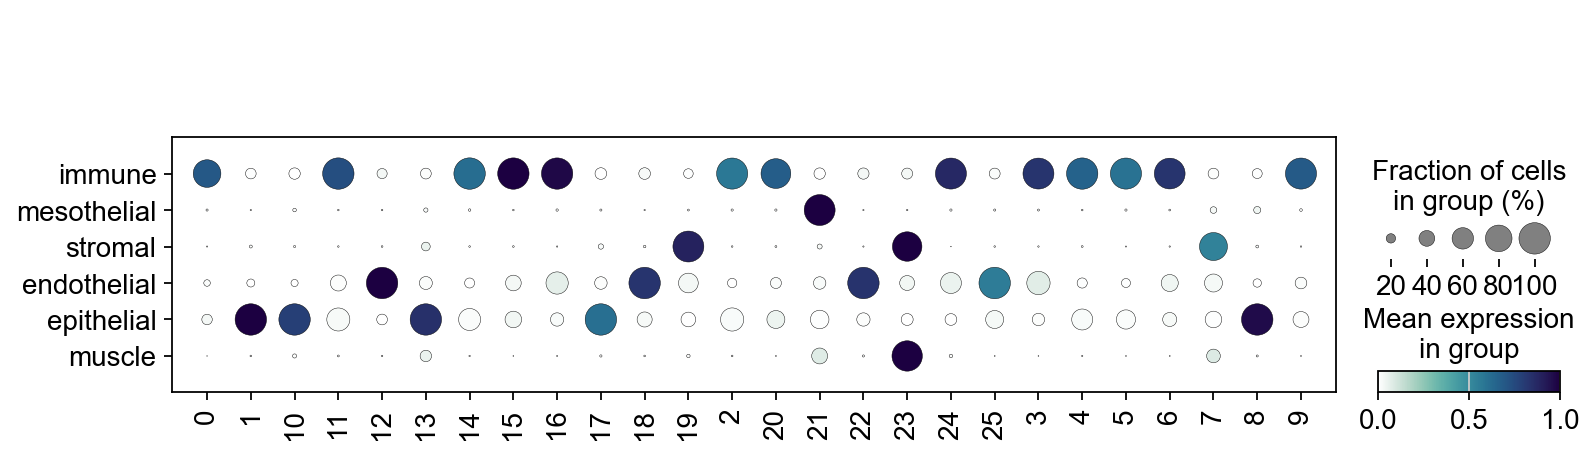

In [14]:
standard_scale='var'
# standard_scale=None
sc.pl.dotplot(adata, top_level_cell_types, swap_axes=True, groupby=cluster_type, cmap=cmr.ocean_r, dendrogram=False, standard_scale=standard_scale)

### Initial Reorder

In [ ]:
old_order = list(adata.obs[cluster_type].cat.categories)
print(list(adata.obs[cluster_type].cat.categories))

In [ ]:
new_order = ['6', '26',
             'Th1','Tex','Treg','Tnaive','T',
             '13', '17', '1', '7', '20','2', '2b',
             '19', '19b',
             '0',
             '21b', 
             '16','8','25','8c',
             '18','14', '10','4', '12', 
             '11', '24', '15', '28',
             
             '3', '5', '27', '8d', '15b', '21','22', '23', ]
print( [item for item in old_order if item not in new_order] )
print( [item for item in new_order if item not in old_order] )

In [ ]:
standard_scale='var'
# standard_scale=None
sc.pl.dotplot(adata, top_level_cell_types, swap_axes=True, groupby=cluster_type, cmap=cmr.ocean_r, categories_order=new_order, dendrogram=False, standard_scale=standard_scale)

### Annotation with Complete Dictionary

In [ ]:
marker_dict = {
'Immune': ['Ptprc','Dock2'],
'Myeloid': ['Fgr', 'Nfam1','Csf2rb','Cd300lf', ], 
# 'macrophage': ['Mertk', 'Dapk1','Sbf2', 'Tmcc3', 'Tgfbr1', 'Creb5', 'Dst'],   # 'Tbxas1', 'Mrc1', 'Nrp2', 'Myo1e'
# 'AM': ['Il18', 'Chil3','Krt79', 'Atp10a', 'Kcnip4','Adgrl2', 'Card11',],  # 'Marco', 'Siglec1', 'Pparg', 'Lilra5',
# 'M-C1q': ['C1qb', 'C1qc', 'C1qa', 'Psd3', 'Mir99ahg', 'Itga9'],   # 'Ophn1', 'Vcam1', 'Cacna1a'
# 'iMon': ['Arhgef37', 'Add3', 'Cd244a', 'Zfyve9', 'Plac8'],   # 'Ms4a4a', 'Adgre4', 'Vcan', 'Sell', 'Nhsl2', 'Gm13710',
# 'M-t1': ['Abcg1', 'F7', 'Atp6v0d2', 'Ly75',  'Gpnmb', 'Iqsec1'],   # 'Gm6209','Lgals3', 'Sgk1', 
# 'M-t2' : ['Ptpro', 'Inpp4b', 'Slc9a9', 'Plcl1', 'Ms4a6c', 'Ccr2', 'Lst1'],    # 'Plbd1', 
    
# 'DC' : ['Flt3', 'Adam23', 'Zbtb46' ],
# 'pDC' : ['Siglech', 'Grm8', 'Tubgcp5'], #  plasmacytoid DCs
# 'neutrophil': ['Il1b', 'Csf3r'],  
# 'N1': ['Padi4', 'Cd101', 'Gsdme', 'Nlrp12'],
# 'N2': ['Ccrl2', 'Cxcl2','Hcar2', 'Ccl3',],
    
'Lymphoid': ['Ikzf3', 'Satb1', 'Gimap3'],
    
'B lineage': ['Bank1', 'Iglc2', 'Pou2af1'],
'B1': [ 'Ms4a1', 'Cxcr5', 'Fcmr'],  
'B2': ['Jchain', 'Igha', 'Iglv1',],
    
'T lineage': ['Cd3e','Cd3d','Cd3g','Lat','Camk4','Trbc2'], 
'Th1': ['Cd40lg','Olfr60','Vax2', 'Apol7b' ], 
'Tnaive': ['Tcf7','Trat1','Cnga1', 'Nsg2', 'Tdrp'], 
'Treg': ['Tnfrsf4','Tnfrsf18','Il2ra','Ctla4','Tigit','Foxp3','Ikzf4','Il1rl1','Neb'], 
'Tex': ['Lag3','Cd8a','Nkg7','Cxcr6','Nrgn','Xcl1'], 

'NK': [ 'Gzma', 'Ccl5',], 
    
'Mesenchyme': ['Col1a2', 'Nhs', 'Cyp7b1'], # , 'Col3a1', 'Rarres2',
    
'Mesothelial': ['Upk3b',  'Wt1', 'Msln', 'Wt1os'],     

'Stromal': ['Ism1', 'Adcy2'],
'Fibroblast': ['Spon1','Unc5c','Slc36a2'],  
# 'AF1': ['Mfap4',  'Cdo1'], 
# 'AF2': ['Col1a1', 'Gsn', 'Itgb8'],  
# 'Pericyte': ['Trpc6', 'Notch3', 'Pdgfrb', 'Postn', 'Gucy1b1', 'Gucy1a1', 'Kcnq5', 'Clstn2'], 
'SMC': ['Hhip',  'Ntrk3',  'Aspn', 'Kcnb2', 'Hpse2', 'Cdh4',],
    
'Endothelial': ['Pecam1','Adgrl4', 'Calcrl', 'Cyyr1', 'Ldb2','Shank3','Egfl7'] ,
'Blood vessels': ['Flt1', 'Tspan7'],
# 'CAP1': ['Gm50250', 'Sox17', 'Ntrk2',],
# 'CAP2': ['Car4', 'Ednrb'],
# 'AEC': ['Gja5', 'Bmx', 'Olfm2', 'Esr2'],
# 'VEC': ['Ackr3', 'Slc6a2', 'Prss23', 'Gask1b', 'Mmp16', 'Samd5'],  
'LEC': ['Ccl21a', 'Mmrn1', 'Prox1', 'Flt4'], 

'Epithelial': ['Prdm16', 'Nkx2-1', 'Sfta3-ps', 'Eya2',  'Chka', 'Pip5k1b',],   
'Ciliated': ['Foxj1', 'Cdhr3', 'Cdhr4', 'Ccdc153', 'AU040972', 'Dynlrb2', 'Tppp3', 'Tmem212'], 
'Secretory': ['Scgb1a1', 'Cyp2f2', 'Gabrp'], 
# 'AT1': [ 'Rtkn2', 'Hopx', 'Scel'],
# 'AT2': ['Lamp3', 'Sftpc', 'Slc34a2', 'Etv5', 'Hc'], 
# 'AT2-t1': ['Tnfrsf1b', 'Tgtp1', 'Clu', 'Gm20275', 'Tnip3', 'Tnfrsf11b'],
# 'AT2-t2': ['Slc26a4','F830016B08Rik'],
}

marker_dict, msg = sm.validate_dict(marker_dict, adata.var_names)
print(msg)
my_cell_types = list(marker_dict.keys())

gene_dict = marker_dict
# add cell type scores to .obs
for key in gene_dict:
    genes = gene_dict[key]
    markers_df = adata[:,genes].to_df()
    for column in markers_df.columns:
        n = 1 # min max normalization, use average of n values to calculate min max
        markers_df[column] = (markers_df[column] - markers_df[column].nsmallest(n).mean()) 
        markers_df[column] = markers_df[column] / markers_df[column].nlargest(n).mean()
    markers_df[key] = markers_df.mean(axis=1)
    adata.obs[key] = markers_df[key]

In [ ]:
old_order = list(adata.obs[cluster_type].cat.categories)
print(list(adata.obs[cluster_type].cat.categories))

In [ ]:
new_order = ['13', '17', '1', '7', '20','2', '2b',
             '6', '26', 
             'Th1','Tex','Treg','Tnaive','T',
             '19', '19b',
             '0',
             '21b', 
             '16','8','25','8c',
             '11', '24', '15', '28',
             '10','4', '12', '18','14', 
             
             '3', '5', '8d', '15b', '21','22', '23', '27', ]
print( [item for item in old_order if item not in new_order] )
print( [item for item in new_order if item not in old_order] )

In [ ]:
plt.rcParams.update({'font.size': 16}) 
standard_scale='var'
# standard_scale=None
sc.pl.dotplot(adata, my_cell_types, swap_axes=True, groupby=cluster_type, categories_order=new_order, cmap=cmr.ocean_r, dendrogram=False, standard_scale=standard_scale)

In [ ]:
plt.rcParams.update({'font.size': 16}) 
standard_scale='var'
# standard_scale=None
sc.pl.dotplot(adata, marker_dict, swap_axes=True, groupby=cluster_type, categories_order=new_order, cmap=cmr.ocean_r, dendrogram=False, standard_scale=standard_scale)

In [ ]:
rcParams['figure.figsize'] = 12, 3
tmp = pd.crosstab(adata.obs[cluster_type],adata.obs['sample'], normalize='index')
tmp = tmp.reindex(new_order)
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax = sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, groupby=cluster_type, order=new_order, show=False)
ax.set_ylim(bottom=0,top=6000)
ax = sc.pl.violin(adata, ['total_counts'], jitter=0.4, groupby=cluster_type, order=new_order, show=False)
ax.set_ylim(bottom=0,top=20000)

### Number of cells in each cluster

List number of cells in each cluster

In [ ]:
clusters = adata.obs[cluster_type].cat.categories.tolist()
samples = adata.obs['sample'].cat.categories.tolist()
count_matrix = []

for cluster in clusters:
    c = adata[adata.obs[cluster_type] == cluster,:]
    count_list = []
    for sample in samples:
        count_list.append(len(c[c.obs['sample'] == sample,:]))
    count_matrix.append(count_list)

cell_count_df = pd.DataFrame(count_matrix, columns=samples, index=clusters)

cell_count_df = cell_count_df.reindex(new_order)
#Total sum per row: 
cell_count_df.loc[:,'Total'] = cell_count_df.sum(axis=1)
#Total sum per column: 
cell_count_df.loc['Total',:]= cell_count_df.sum(axis=0)
cell_count_df

In [ ]:
stop here

## Remove bad clusters

Low counts poorly resolved cells:

3: may be neutrophils but not very convincing

5: low counts, left over T cells that are mixed with macrophage and B cells

8d : low counts, very mixed

15b: very low counts, seems to be mainly endothelial but other cell types as well.

21: low counts, mainly mesenchyme but mixed

22: very mixed

23: very mixed

27: low counts mix of ciliated and secretory

In [ ]:
remove = ['3', '5', '8d', '15b', '21','22', '23', '27',] # remove clusters 
for cluster in remove:
    adata = adata[adata.obs[cluster_type] !=cluster, :]
# update new_order
new_order = [item for item in new_order if item not in remove]
print(new_order)

### Merge Clusters
Merge clusters 4, 1, 1b, 2 

In [ ]:
i=0
new_col = []
for item in adata.obs['my_clust_1']:
    if item == '7':
        new_col.append('1')
    elif item == '17':
        new_col.append('1')
    elif item == '20':
        new_col.append('1')
    elif item == '16':         # merge alveolar fibroblasts
        new_col.append('8')
    else:
        new_col.append(item)
    i = i+1    
    
adata.obs['my_clust_1'] = new_col
adata.obs['my_clust_1'] = adata.obs['my_clust_1'].astype('category')

In [ ]:
new_order = ['13', '1','2', '2b',
             '6', '26', 
             'Th1','Tex','Treg','Tnaive','T',
             '19', '19b',
             '0',
             '21b', 
             '8','25','8c',
             '11', '24', '15', '28',
             '10','4', '12', '18','14',]
print( [item for item in old_order if item not in new_order] )
print( [item for item in new_order if item not in old_order] )

In [ ]:
test_gene = 'SMC' #'Foxp3' #'C1qb', 'C1qc', 'C1qa'
plt.rcParams.update({'font.size': 15})   # cluster labels
fig, axs = plt.subplots(1, 2, figsize=(14,7),constrained_layout=True)
sc.pl.umap(adata, color=cluster_type, size=30, ax=axs[0], show=False, legend_loc='on data', palette=sm.wes)
sc.pl.umap(adata, color_map=sm.fire, color=test_gene, ax=axs[1], show=False)

In [ ]:
plt.rcParams.update({'font.size': 16}) 
standard_scale='var'
# standard_scale=None
sc.pl.dotplot(adata, my_cell_types, swap_axes=True, groupby=cluster_type, categories_order=new_order, cmap=cmr.ocean_r, dendrogram=False, standard_scale=standard_scale)

## Save Data
Save the data for further analysis.

In [ ]:
adata.write_h5ad(final_file)

### Save raw data set

In [ ]:
filtered_data = sc.read_h5ad(filtered_file)
filtered_data[filtered_data.obs_names.isin(adata.obs_names)].write_h5ad(final_filtered_file)

In [ ]:
print(f"Original adata shape: {adata.shape}")
print(f"Original filtered shape: {filtered_data.shape}")
print(f"Final raw shape: {filtered_data[filtered_data.obs_names.isin(adata.obs_names)].shape}")
# Delete unneeded anndata objects 
del filtered_data
# Force garbage collection
gc.collect()

### Examine Top Level Cell Types

In [ ]:
top_dict = {
'Immune': ['13', '1','2', '2b',
             '6', '26', 
             'Th1','Tex','Treg','Tnaive','T',
             '19', '19b',
             '0',],
'Mesothelial': ['21b'],
'Stromal': ['8','25','8c'],
'Endothelial': ['11', '24', '15', '28'],
'Epithelial': ['10','4', '12', '18','14']
}

In [ ]:
cl_annotation ={}

for cell_type, cluster_num in top_dict.items():
    for x in cluster_num:
        cl_annotation[x] = cell_type
# cl_annotation

In [ ]:
plt.rcParams['figure.figsize']=(7,7) #rescale figures
adata.obs["celltype_annotation"] = adata.obs[cluster_type].map(cl_annotation)
sc.pl.umap(adata, color=["celltype_annotation"])

In [ ]:
sc.pl.umap(adata, color=top_level_cell_types,vmin=0,
    vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum, to prevent outliers from making expression in other cells invisible. Note that this can cause problems for extremely lowly expressed genes.
    sort_order=False,  # do not plot highest expression on top, to not get a biased view of the mean expression among cells
    frameon=False, color_map=sm.fire)

In [ ]:
clusters = adata.obs[cluster_type].cat.categories.tolist()
samples = adata.obs['sample'].cat.categories.tolist()
count_matrix = []
cell_type = []

for cluster_num in clusters:
    c = adata[adata.obs[cluster_type] == cluster_num,:]
    count_list = []
    for sample in samples:
        count_list.append(len(c[c.obs['sample'] == sample,:]))
    count_matrix.append(count_list)
    if cluster_num in list(cl_annotation.keys()):
        cell_type.append(cl_annotation[cluster_num])
    else:
        cell_type.append(np.nan)

df = pd.DataFrame(count_matrix, columns=samples, index=clusters)
df.insert(0, 'cell_type', cell_type)
#Total sum per row: 
df.loc[:,'Total'] = df.sum(axis=1, numeric_only=True)
df = df.sort_values(by=['cell_type'])
#Total sum per column: 
df.loc['Total',:]= df.sum(axis=0, numeric_only=True)
df

In [ ]:
df.groupby('cell_type').sum()

#### Get genes by counts and total counts for each major cell type

In [ ]:
df =  adata.obs[['n_genes_by_counts', 'total_counts', 'celltype_annotation','sample']]
df.groupby(['sample', 'celltype_annotation'], observed=False).mean()

In [ ]:
stop here

## Find positive marker genes
Get average expression for all genes.
Then get list of ranked genes that past threshold difference between expression in cluster and all other clusters

In [ ]:
## select comparison clusters
test = ['13', '20b', '14', '12', '4', '20', '24',]
categories = adata.obs[cluster_type].cat.categories.tolist()
rest = [x for x in categories if x not in test] # compare to everything else
# rest = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '18b', '19', '2', '20b', '21', '22', '23', '24b', '25', '2b', '2c', '3', '3b', '3c', '4', '5', '6', '7', '8', '9']
print('test = ', test)
print('rest = ', rest)

# statistical texts
adata.obs["comparison"] = np.nan
adata.obs.loc[adata.obs[cluster_type].isin(test), "comparison"] = "A"
adata.obs.loc[adata.obs[cluster_type].isin(rest), "comparison"] = "B"

# select significantly different genes between groups, use two tests for robustness
sc.tl.rank_genes_groups(adata, "comparison", groups=['A'], reference='B', method='t-test')
ls_t_test = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(500).values.tolist()
ls_t_test = [i for s in ls_t_test for i in s]
sc.tl.rank_genes_groups(adata, "comparison", groups=['A'], reference='B', method='wilcoxon')
ls_wilcox = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(500).values.tolist()
ls_wilcox = [i for s in ls_wilcox for i in s]
sig_genes = list(set(ls_t_test + ls_wilcox))

# rcParams['figure.figsize'] = 8, 3
# sc.pl.rank_genes_groups(bdata, groups=['A'], n_genes=40)

In [ ]:
ls = pd.DataFrame(adata.uns['rank_genes_groups']['names']).values.tolist()
# extract list of names
names = [i for s in ls for i in s]  
ls = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj']).values.tolist()
# extract list of names
pvals_adj = [i for s in ls for i in s] 
ls = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']).values.tolist()
# extract list of names
logfoldchanges = [i for s in ls for i in s] 
ls = pd.DataFrame(adata.uns['rank_genes_groups']['pvals']).values.tolist()
# extract list of names
pvals = [i for s in ls for i in s] 

df_junk = pd.DataFrame(list(zip(pvals, pvals_adj, logfoldchanges)),columns = ['pvals', 'pvals_adj', 'logfoldchanges'], index = names)
# df_junk.loc['Gm28497']
# df_junk

In [ ]:
av_gene_cluster = pd.DataFrame(columns=adata.var_names, index=adata.obs[cluster_type].cat.categories)                                                                                                 

# get average for each gene for each cluster
for clust in adata.obs[cluster_type].cat.categories: 
    av_gene_cluster.loc[clust] = adata[adata.obs[cluster_type].isin([clust]),:].X.mean(0) 

In [ ]:
threshold = 0.2 # cut-off to eliminate other groups, may have to try a few values, start with 0.3
    
row_names = av_gene_cluster.index.values # get cluster numbers
# print(row_names)
marker_genes = []
for gene in sig_genes:
    all_low = True
    neg_average = False
    av = []
    for group in test:
        av.append(av_gene_cluster[gene][group])  # average expression of test group
    test_average = np.average(av)
    if test_average < 0:
        neg_average = True
    for i, item in enumerate(av_gene_cluster[gene]):
        if row_names[i]  in rest:
            if item > threshold*test_average:
                all_low = False
    if all_low and not neg_average:
        marker_genes.append(gene)
print(marker_genes) 

In [ ]:
plt.rcParams.update({'font.size': 15}) 
sc.pl.dotplot(adata, marker_genes, swap_axes=True, groupby=cluster_type, categories_order=new_order, cmap=cmr.ocean_r, dendrogram=False, standard_scale='var')

In [ ]:
'Slfn4', 'Trim30b', 'Asprv1', 'Slc40a1', 'Csta2', 

In [ ]:
test_gene = 'Ddr2' #''Ddr2',
plt.rcParams.update({'font.size': 15})   # cluster labels
fig, axs = plt.subplots(1, 2, figsize=(14,7),constrained_layout=True)
sc.pl.umap(adata, color=cluster_type, size=30, ax=axs[0], show=False, legend_loc='on data', palette=sm.wes)
sc.pl.umap(adata, color_map=plt.cm.Blues, color=test_gene, ax=axs[1], show=False)

In [ ]:
g = ['Cd11b','Cd11c','Cd16','Cd31','Cd64','Cd71',]
# g = ['Cd34','Cd68','Cd14','Cd34','Cd68','Cd80','Cd86','Cd163','Ccr5']
for g1 in g:
    if g1 in adata.var_names:
        print(g1)

In [ ]:
m_genes = ['Cd34','Cd68','Cd14','Cd34','Cd68','Cd80','Cd86','Cd163','Ccr5']
# 'Cd11b','Cd11c','Cd16','Cd31','Cd64','Cd71',

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,7),constrained_layout=True)
sc.pl.umap(adata, color='Ccr5', color_map=sm.fire, vmin=0, vmax="p99",sort_order=False,frameon=False, ax=axs[0], show=False)
sc.pl.umap(adata, color='Cd11b', color_map=sm.fire, vmin=0, vmax="p99",sort_order=False,frameon=False, ax=axs[1], show=False)